<a href="https://colab.research.google.com/github/Papekyan/GBM-und-XG/blob/main/Datensatz.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Risikofaktoren für Kardiovaskuläre Herzkrankheiten


## 0. Import von Bibliotheken und Datenveranschaulichung

In [ ]:

import pandas as pd
import numpy as np
import xgboost as xgb
import seaborn as sns #Visualisierung
import matplotlib.pyplot as plt #Visualisierung
from sklearn.model_selection import train_test_split #Split Training- und Testdaten
from sklearn.metrics import recall_score,precision_score, confusion_matrix, classification_report #Evaluation
from sklearn.ensemble import GradientBoostingClassifier #GBM
from sklearn.model_selection import GridSearchCV #hyperparameter tuning
from xgboost import XGBClassifier #XGBoost
from xgboost import plot_tree
import shap



## 1. Datenveranschaulichung

In [ ]:
df = pd.read_csv('heart_data.csv')

df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   index        70000 non-null  int64  
 1   id           70000 non-null  int64  
 2   age          70000 non-null  int64  
 3   gender       70000 non-null  int64  
 4   height       70000 non-null  int64  
 5   weight       70000 non-null  float64
 6   ap_hi        70000 non-null  int64  
 7   ap_lo        70000 non-null  int64  
 8   cholesterol  70000 non-null  int64  
 9   gluc         70000 non-null  int64  
 10  smoke        70000 non-null  int64  
 11  alco         70000 non-null  int64  
 12  active       70000 non-null  int64  
 13  cardio       70000 non-null  int64  
dtypes: float64(1), int64(13)
memory usage: 7.5 MB


,index,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
count,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000
mean,34999.500000,49972.419900,19468.865814,1.349571,164.359229,74.205690,128.817286,96.630414,1.366871,1.226457,0.088129,0.053771,0.803729,0.499700
std,20207.403759,28851.302323,2467.251667,0.476838,8.210126,14.395757,154.011419,188.472530,0.680250,0.572270,0.283484,0.225568,0.397179,0.500003
min,0.000000,0.000000,10798.000000,1.000000,55.000000,10.000000,-150.000000,-70.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,17499.750000,25006.750000,17664.000000,1.000000,159.000000,65.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
50%,34999.500000,50001.500000,19703.000000,1.000000,165.000000,72.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
75%,52499.250000,74889.250000,21327.000000,2.000000,170.000000,82.000000,140.000000,90.000000,2.000000,1.000000,0.000000,0.000000,1.000000,1.000000
max,69999.000000,99999.000000,23713.000000,2.000000,250.000000,200.000000,16020.000000,11000.000000,3.000000,3.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
df.info(-3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   index        70000 non-null  int64  
 1   id           70000 non-null  int64  
 2   age          70000 non-null  int64  
 3   gender       70000 non-null  int64  
 4   height       70000 non-null  int64  
 5   weight       70000 non-null  float64
 6   ap_hi        70000 non-null  int64  
 7   ap_lo        70000 non-null  int64  
 8   cholesterol  70000 non-null  int64  
 9   gluc         70000 non-null  int64  
 10  smoke        70000 non-null  int64  
 11  alco         70000 non-null  int64  
 12  active       70000 non-null  int64  
 13  cardio       70000 non-null  int64  
dtypes: float64(1), int64(13)
memory usage: 7.5 MB


In [ ]:
#Kardinalität der Spalten
print(df.nunique())

index          70000
id             70000
age             8076
gender             2
height           109
weight           287
ap_hi            153
ap_lo            157
cholesterol        3
gluc               3
smoke              2
alco               2
active             2
cardio             2
dtype: int64


## 2. Datenaufbereitung

In [ ]:
#Alter in Jahre umrechnen
df['age_years'] = df ['age']/365

In [ ]:
#BMI und nicht benötigte Spalten entfernen
df['male'] = df['gender'].apply(lambda x: 1 if x == 1 else 0)
df['female'] = df['gender'].apply(lambda x: 1 if x == 2 else 0)
df['bmi'] = df['weight'] / ((df['height'] / 100) ** 2)
df = df.drop(['index','id','height','weight','gender'],axis=1)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   age          70000 non-null  int64  
 1   ap_hi        70000 non-null  int64  
 2   ap_lo        70000 non-null  int64  
 3   cholesterol  70000 non-null  int64  
 4   gluc         70000 non-null  int64  
 5   smoke        70000 non-null  int64  
 6   alco         70000 non-null  int64  
 7   active       70000 non-null  int64  
 8   cardio       70000 non-null  int64  
 9   age_years    70000 non-null  float64
 10  male         70000 non-null  int64  
 11  female       70000 non-null  int64  
 12  bmi          70000 non-null  float64
dtypes: float64(2), int64(11)
memory usage: 6.9 MB


<ipython-input-8-07c32f448318>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df['cardio'],palette=sns.color_palette() )
<ipython-input-8-07c32f448318>:3: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  sns.countplot(x=df['cardio'],palette=sns.color_palette() )


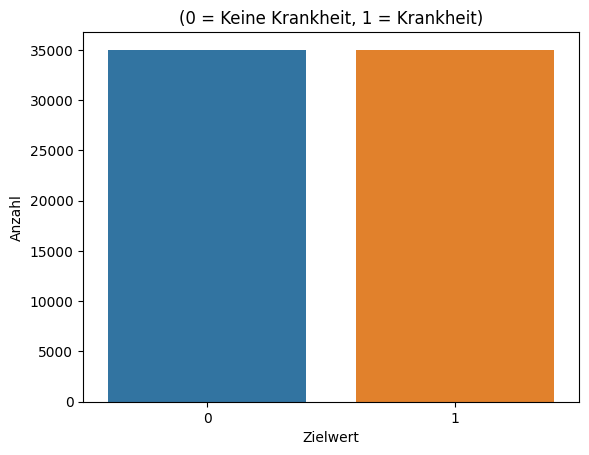

In [ ]:
#Aufteilung der Zielvariable

sns.countplot(x=df['cardio'],palette=sns.color_palette() )
plt.xlabel("Zielwert")
plt.ylabel("Anzahl" )
plt.title("(0 = Keine Krankheit, 1 = Krankheit)")

plt.savefig('Zielwert.pdf',dpi=1500,bbox_inches='tight')

plt.show()

In [ ]:
#Aufteilung des Datensatzes in Prädiktoren und Zielwerte
X = df.drop('cardio',axis=1)
Y = df['cardio']

In [ ]:
#Überprüfen ob NaN Werte vorhanden sind
X.isnull().sum()

,0
age,0
ap_hi,0
ap_lo,0
cholesterol,0
gluc,0
smoke,0
alco,0
active,0
age_years,0
male,0


In [ ]:
#Daten splitten
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)


## 3. Anwendung Gradient Boosting Classifier

In [ ]:
#Modell trainieren

gbr = GradientBoostingClassifier(verbose=1)
gbr = gbr.fit(X_train, Y_train)

      Iter       Train Loss   Remaining Time 
         1           1.3381            8.67s
         2           1.2989            9.05s
         3           1.2666            8.96s
         4           1.2399            8.93s
         5           1.2175            8.99s
         6           1.1989           10.30s
         7           1.1833           10.72s
         8           1.1699           12.95s
         9           1.1589           14.13s
        10           1.1494           14.41s
        20           1.1037           10.03s
        30           1.0896            8.00s
        40           1.0828            6.49s
        50           1.0789            5.23s
        60           1.0765            4.37s
        70           1.0746            3.38s
        80           1.0730            2.21s
        90           1.0718            1.08s
       100           1.0705            0.00s


In [ ]:
#Trainiertes Modell auf Test Set anwende
Y_pred = gbr.predict(X_test)

In [ ]:
#Evaluationsreport und Konfusionsmatrix generieren
report = classification_report(
    Y_test,
    Y_pred,
    labels=[1, 0],

    digits=2
)

print("Classification Report:")
print(report)


cm = confusion_matrix(Y_test, Y_pred, labels=[1, 0])
print(cm)

print('Recall:')
print(round((recall_score(Y_test, Y_pred, pos_label=1)),2))



Classification Report:
              precision    recall  f1-score   support

           1       0.76      0.71      0.73      7012
           0       0.73      0.77      0.75      6988

    accuracy                           0.74     14000
   macro avg       0.74      0.74      0.74     14000
weighted avg       0.74      0.74      0.74     14000

[[4970 2042]
 [1603 5385]]
Recall:
0.71


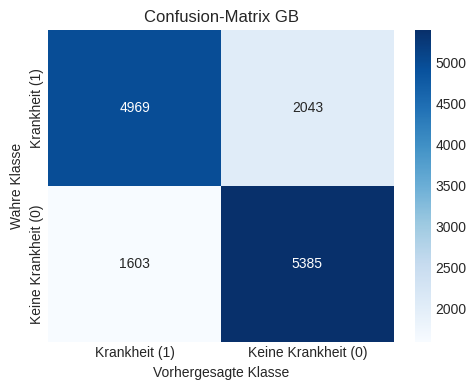

In [ ]:
labels = ['Krankheit (1)','Keine Krankheit (0)' ]

# 2. Heatmap plotten
plt.figure(figsize=(5, 4))
sns.heatmap(
    cm,
    annot=True,         # Zahlen (z. B. TN, FP, FN, TP) in die Zellen schreiben
    fmt='d',            # 'd' steht für ganze Zahlen (integer)
    cmap='Blues',       # Blau-Skala; du kannst auch 'Reds', 'YlGnBu' etc. nehmen
    xticklabels=labels, # Achsenbeschriftung unten (Predicted Labels)
    yticklabels=labels  # Achsenbeschriftung links (True Labels)
)

plt.xlabel('Vorhergesagte Klasse')
plt.ylabel('Wahre Klasse')
plt.title('Confusion-Matrix GB')
plt.tight_layout()
plt.show()

### 3.1 Hyperparamter Tuning

In [ ]:
#Parameter festlegen über die varriert werden darf
param_grid = {
    'max_depth': [1,3,5],
    'learning_rate': [0.01, 0.03, 0.05, 0.1, 0.2],
    'n_estimators': [10, 50, 100, 150, 200, 300, 400, 500],}

gbr_tuning = GridSearchCV(gbr, param_grid, scoring= 'recall', cv=3)
gbr_tuning.fit(X_train, Y_train)

      Iter       Train Loss   Remaining Time 
         1           1.3827            0.31s
         2           1.3791            0.28s
         3           1.3756            0.24s
         4           1.3722            0.20s
         5           1.3688            0.19s
         6           1.3655            0.15s
         7           1.3623            0.11s
         8           1.3592            0.07s
         9           1.3561            0.04s
        10           1.3530            0.00s
      Iter       Train Loss   Remaining Time 
         1           1.3825            0.30s
         2           1.3788            0.26s
         3           1.3751            0.24s
         4           1.3716            0.22s
         5           1.3681            0.18s
         6           1.3646            0.14s
         7           1.3613            0.10s
         8           1.3580            0.07s
         9           1.3547            0.04s
        10           1.3516            0.00s
      It

KeyboardInterrupt: 

In [ ]:
#Parameter und Vorhersage des verbesserten Models
print(gbr_tuning.best_params_)
gbr_tuned = tuned_model.best_estimator_
Y_tuned_pred = gbr_tuned.predict(X_test)

AttributeError: 'GridSearchCV' object has no attribute 'best_params_'

In [ ]:
#Evaluation des verbesserten Modells
report = classification_report(
    Y_test,
    Y_pred,
    labels=[1, 0],
    digits=2
)

print("Classification Report:\n")
print(report)

print('Konfusionsmatrix:')
cm = confusion_matrix(Y_test, Y_tuned_pred, labels=[1, 0])
print(cm)


print('Recall:')
print(round((recall_score(Y_test, Y_tuned_pred, pos_label=1)),2))

Classification Report:

              precision    recall  f1-score   support

           1       0.76      0.71      0.73      7012
           0       0.72      0.77      0.75      6988

    accuracy                           0.74     14000
   macro avg       0.74      0.74      0.74     14000
weighted avg       0.74      0.74      0.74     14000

Konfusionsmatrix:


AttributeError: 'Series' object has no attribute 'tuned_pred'

## 4.XGBoost Classifier


In [ ]:
XGB = XGBClassifier()
XGB.fit(X_train, Y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [ ]:
Y_pred_XGB = XGB.predict(X_test)

In [ ]:
#Evaluationsreport und Konfusionsmatrix generieren
report = classification_report(
    Y_test,
    Y_pred_XGB,
    labels=[1, 0],
    digits=2
)

print("Classification Report XGBoost:")
print(report)


cm = confusion_matrix(Y_test, Y_pred_XGB, labels=[1, 0])
print('Konfusionsmatrix:')
print(cm)

print('Recall:')
print(round((recall_score(Y_test, Y_pred_XGB, pos_label=1)),2))

Classification Report XGBoost:
              precision    recall  f1-score   support

           1       0.76      0.70      0.73      7012
           0       0.72      0.78      0.75      6988

    accuracy                           0.74     14000
   macro avg       0.74      0.74      0.74     14000
weighted avg       0.74      0.74      0.74     14000

Konfusionsmatrix:
[[4881 2131]
 [1552 5436]]
Recall:
0.7


### 4.1 Hyperparameter Tuning

In [ ]:
param_grid = {
    'max_depth': [1,3,5],
    'learning_rate': [0.01, 0.03, 0.05, 0.1, 0.2],
    'n_estimators': [10, 50, 100, 150, 200, 300, 400, 500],}

XGB_tuning = GridSearchCV(XGB, param_grid, cv=3, scoring='recall', n_jobs=-1)

XGB_tuning.fit(X_train, Y_train)


GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.03, 0.05, 0.1, 0.2],
                         'max_depth': [1, 3, 5],
                         'n_estimators': [10, 50, 100, 150, 200, 300, 400,
                                          500]},
             scoring='recall')

In [ ]:
#Parameter und Vorhersage des verbesserten Models
print(XGB_tuning.best_params_)
XGB_tuned = XGB_tuning.best_estimator_
Y_tuned_pred_XGB = XGB_tuned.predict(X_test)

{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200}


In [ ]:
#Evaluationsreport und Konfusionsmatrix generieren
report = classification_report(
    Y_test,
    Y_tuned_pred_XGB,
    labels=[1, 0],

    digits=2
)

print("Classification Report XGBoost:")
print(report)


cm = confusion_matrix(Y_test, Y_tuned_pred_XGB                                                       , labels=[1, 0])
print('Konfusionsmatrix:')
print(cm)

print('Recall:')
print(round((recall_score(Y_test, Y_tuned_pred_XGB, pos_label=1)),2))

Classification Report XGBoost:
              precision    recall  f1-score   support

           1       0.76      0.71      0.73      7012
           0       0.72      0.77      0.75      6988

    accuracy                           0.74     14000
   macro avg       0.74      0.74      0.74     14000
weighted avg       0.74      0.74      0.74     14000

Konfusionsmatrix:
[[4946 2066]
 [1574 5414]]
Recall:
0.71


<function matplotlib.pyplot.show(close=None, block=None)>

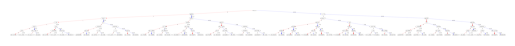

In [ ]:
plot_tree(XGB, num_trees=0)
plt.savefig('XGB_decision_tree_max_depth2.pdf', dpi=2000,bbox_inches='tight')
plt.show



In [ ]:




recall_df = pd.DataFrame({
    'Modell': [
        'GB (default)',
        'GB (tuned)',
        'XGB (default)',
        'XGB (tuned)'
    ],
    'Recall': [
        0.71,
        0.72,
        0.7,
        0.71
    ]
})


<ipython-input-20-4241df7a9c90>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Modell', y='Recall', data=recall_df, palette='Paired')


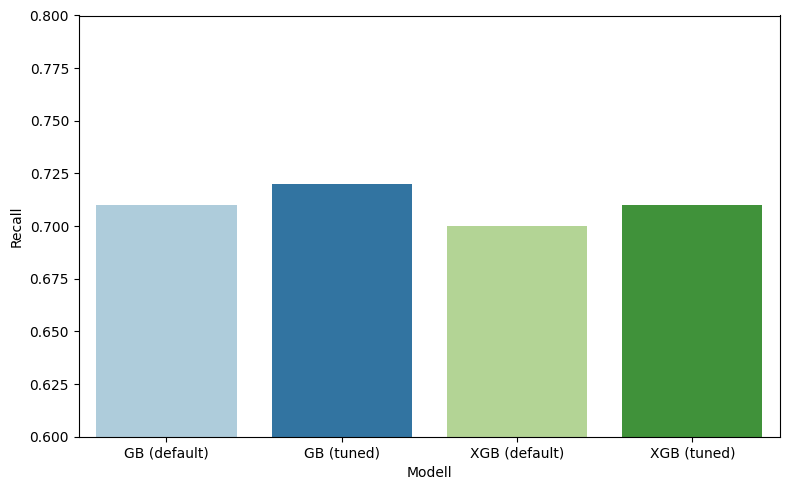

In [ ]:
plt.figure(figsize=(8,5))
sns.barplot(x='Modell', y='Recall', data=recall_df, palette='Paired')
plt.ylim(0.6, 0.8)
plt.ylabel('Recall')
plt.xlabel('Modell')


plt.tight_layout()
plt.savefig('Recall_Vergleich.pdf', dpi=1500, bbox_inches='tight')
plt.show()

In [ ]:
# Create an explainer for XGBoost
explainer = shap.Explainer(XGB_tuned, X_train)  # X_train is your feature set
shap_values = explainer(X_train)  # Compute SHAP values

  7%|=                   | 3812/56000 [00:13<02:57]       

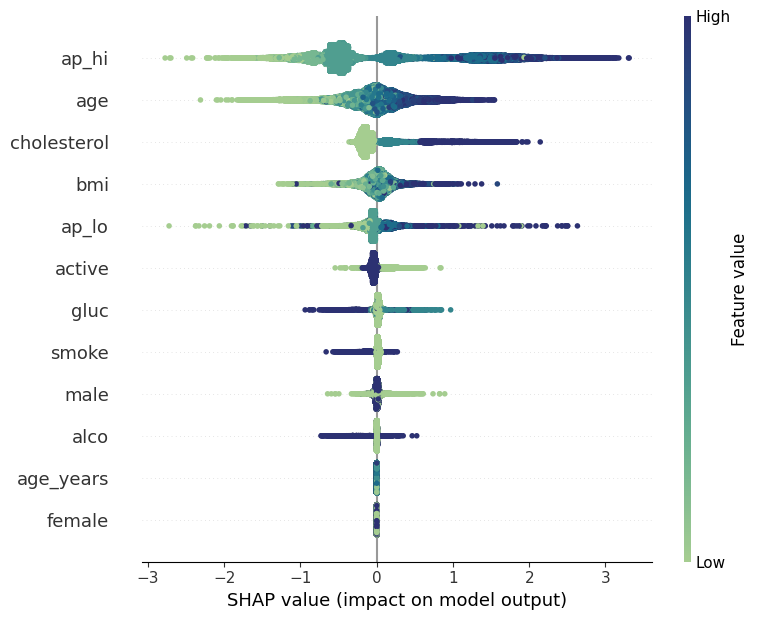

In [ ]:

#shap.summary_plot(shap_values, X_train)
shap.summary_plot(
    shap_values,
    X_train,
    plot_type="dot",       # Punktwolken‐Plot (Bienenstock)
    cmap="crest",        # <- zum Beispiel Matplotlibs “viridis”‐Farbkarte
    show=False )

In [ ]:
# Create an explainer for XGBoost
explainer = shap.Explainer(gbr_tuned, X_train)  # X_train is your feature set
shap_values = explainer(X_train)  # Compute SHAP values

#shap.summary_plot(shap_values, X_train)
shap.summary_plot(
    shap_values,
    X_train,
    plot_type="dot",       # Punktwolken‐Plot (Bienenstock)
    cmap="crest",        # <- zum Beispiel Matplotlibs “viridis”‐Farbkarte
    show=False )